# Transactions Fraud Detection

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Timotej Zatko](https://github.com/timzatko)

## Nature Inspired Algorithms for Feature Selection

- all used on DT, compared with baseline 

We will train the model with selected features on the whole dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

from NiaPy.task import StoppingTask, OptimizationType
from NiaPy.algorithms.basic import GreyWolfOptimizer, FireflyAlgorithm, GeneticAlgorithm, \
    BatAlgorithm, ParticleSwarmOptimization

from src.algorithms.grey_wolf_optimizer_multiprocessing import GreyWolfOptimizerMultiprocessing

from src.dataset import load_processed_data
from src.data_balancing import random_undersample
from src.evaluation import custom_classification_report

from src.classification_benchmark import ClassificationBenchmark

### Load the data

In [3]:
x_train, y_train, x_test, y_test = load_processed_data()

Number of records:
  x_train - 4724
  y_train - 4724
  x_test - 1181
  y_test - 1181


In [4]:
x_train, y_train = random_undersample(x_train, y_train)
len(x_train), len(y_train)

(292, 292)

### Setup classification benchmark

In [5]:
def model_fn():
    return DecisionTreeClassifier(random_state=42)

In [6]:
columns_count = len(x_train.columns)

_x_train, _x_val, _y_train, _y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

benchmark = ClassificationBenchmark(
    model_fn,
    roc_auc_score,
    _x_train,
    _y_train,
    _x_val,
    _y_val
)

In [7]:
def optimize(benchmark, algorithm, nGEN, num_runs = 5):
    """
    Optimize task with GWO optimizer.
    
    :param benchmark: NiaPy.Benchmark to optimize.
    :param algorithm: algorithm object to use for optimization task.
    :param nGEN: number of generations.
    :param num_runs: number of algorithm runs (defaults to 5).
    """
    best_columns = None
    best_score = 0
    
    for i in range(num_runs):
        # when using OptimizationType.MAXIMIZATION, the library will fail
        # we use OptimizationType.MINIMIZATION instead and invert the score
        task = StoppingTask(
            D=benchmark.get_length(),
            nGEN=nGEN,
            optType=OptimizationType.MINIMIZATION,
            benchmark=benchmark
        )
        
        solution_vec, score = algorithm.run(task=task)    
        
        # invert the score
        score = 1 - score
        columns = benchmark.select_columns(solution_vec)
        
        print('--------------')
        print(f'Run {i + 1}')
        print('--------------')
        print(f'Score: {score}')
        print(f'Number of features selected: {len(columns)}\n')
        print('\n')
        
        if score > best_score:
            best_score = score
            best_columns = columns

    print(f'\nBest score of {num_runs} runs: {best_score}')
    print(f'Number of features selected: {len(best_columns)}')
            
    return best_columns

### Grey Wolf Optimization (GWO)

Find the optimal combination of columns.

In [8]:
%%time

columns = optimize(benchmark, GreyWolfOptimizerMultiprocessing(nodes=4, NP=25), 100)

--------------
Run 1
--------------
Score: 0.8137931034482759
Number of features selected: 212




Best score of 1 runs: 0.8137931034482759
Number of features selected: 212
CPU times: user 20.7 s, sys: 18.9 s, total: 39.5 s
Wall time: 55.2 s


not fraud
precision: 0.6275555555555555
recall: 0.9684499314128944
f1-score: 0.761596548004315
support: 729


is fraud
precision: 0.5892857142857143
recall: 0.07300884955752213
f1-score: 0.12992125984251968
support: 452


accuracy: 0.6257408975444538


macro avg
precision: 0.6084206349206349
recall: 0.5207293904852083
f1-score: 0.4457589039234173
support: 1181


weighted avg
precision: 0.6129086730373776
recall: 0.6257408975444538
f1-score: 0.5198376739576329
support: 1181


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.6084206349206349




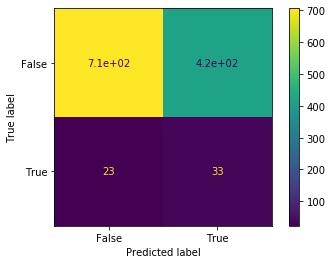

In [9]:
clf = model_fn()
clf = clf.fit(x_train[columns], y_train)
custom_classification_report(clf, x_test[columns], y_test)

We found the best solution from 5 independent runs of GWO algorithm. During every run we captured a different solution. For the final submission, we probably would not like to use "the best one", because we would like to have some variance. Maybe we can try to merge these solution together.

### Firefly Algorithm (FA)

In [10]:
%%time

columns = optimize(benchmark, FireflyAlgorithm(), 100)

--------------
Run 1
--------------
Score: 0.8643678160919541
Number of features selected: 217




Best score of 1 runs: 0.8643678160919541
Number of features selected: 217
CPU times: user 20.6 s, sys: 44.3 ms, total: 20.6 s
Wall time: 20.6 s


not fraud
precision: 0.6951111111111111
recall: 0.972636815920398
f1-score: 0.8107827890098496
support: 804


is fraud
precision: 0.6071428571428571
recall: 0.09018567639257294
f1-score: 0.15704387990762123
support: 377


accuracy: 0.6909398814563928


macro avg
precision: 0.6511269841269841
recall: 0.5314112461564855
f1-score: 0.4839133344587354
support: 1181


weighted avg
precision: 0.6670297971855973
recall: 0.6909398814563928
f1-score: 0.6020956012608741
support: 1181


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.6511269841269841




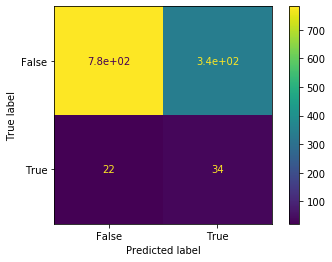

In [11]:
clf = model_fn()
clf = clf.fit(x_train[columns], y_train)
custom_classification_report(clf, x_test[columns], y_test)

### Genetic Algorithm (GA)

In [12]:
%%time

columns = optimize(benchmark, GeneticAlgorithm(), 100)

--------------
Run 1
--------------
Score: 0.8482758620689657
Number of features selected: 214




Best score of 1 runs: 0.8482758620689657
Number of features selected: 214
CPU times: user 32.6 s, sys: 72.9 ms, total: 32.7 s
Wall time: 32.6 s


not fraud
precision: 0.7431111111111111
recall: 0.9698375870069605
f1-score: 0.8414695520885757
support: 862


is fraud
precision: 0.5357142857142857
recall: 0.09404388714733543
f1-score: 0.16
support: 319


accuracy: 0.7332768839966131


macro avg
precision: 0.6394126984126984
recall: 0.531940737077148
f1-score: 0.5007347760442878
support: 1181


weighted avg
precision: 0.6870911387981666
recall: 0.7332768839966131
f1-score: 0.6573977594414498
support: 1181


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.6394126984126983




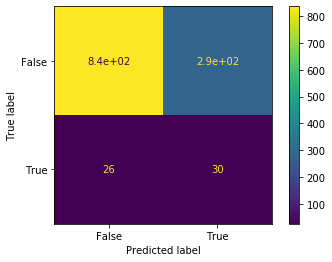

In [13]:
clf = model_fn()
clf = clf.fit(x_train[columns], y_train)
custom_classification_report(clf, x_test[columns], y_test)

### Particle Swarm Optimization (PSO)

In [14]:
%%time

columns = optimize(benchmark, ParticleSwarmOptimization(), 100)

--------------
Run 1
--------------
Score: 0.8810344827586207
Number of features selected: 210




Best score of 1 runs: 0.8810344827586207
Number of features selected: 210
CPU times: user 23.8 s, sys: 31.9 ms, total: 23.8 s
Wall time: 23.7 s


not fraud
precision: 0.7324444444444445
recall: 0.9751479289940829
f1-score: 0.8365482233502538
support: 845


is fraud
precision: 0.625
recall: 0.10416666666666667
f1-score: 0.1785714285714286
support: 336


accuracy: 0.7273497036409822


macro avg
precision: 0.6787222222222222
recall: 0.5396572978303747
f1-score: 0.5075598259608411
support: 1181


weighted avg
precision: 0.7018759996236711
recall: 0.7273497036409822
f1-score: 0.6493507609915026
support: 1181


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.6787222222222222




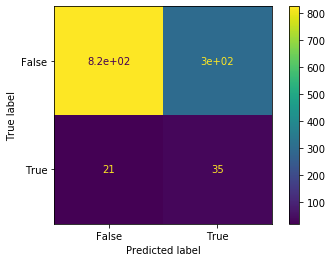

In [15]:
clf = model_fn()
clf = clf.fit(x_train[columns], y_train)
custom_classification_report(clf, x_test[columns], y_test)

### Bat Algorithm (BA)

In [16]:
%%time

columns = optimize(benchmark, BatAlgorithm(), 100)

--------------
Run 1
--------------
Score: 0.8471264367816091
Number of features selected: 216




Best score of 1 runs: 0.8471264367816091
Number of features selected: 216
CPU times: user 42.3 s, sys: 140 ms, total: 42.5 s
Wall time: 42.4 s


not fraud
precision: 0.6746666666666666
recall: 0.9644218551461246
f1-score: 0.7939330543933054
support: 787


is fraud
precision: 0.5
recall: 0.07106598984771574
f1-score: 0.12444444444444445
support: 394


accuracy: 0.6663844199830652


macro avg
precision: 0.5873333333333333
recall: 0.5177439224969201
f1-score: 0.45918874941887494
support: 1181


weighted avg
precision: 0.6163951453570421
recall: 0.6663844199830652
f1-score: 0.5705812234704848
support: 1181


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
Score: 0.5873333333333334




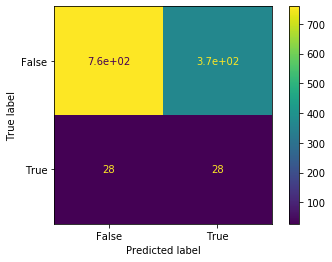

In [17]:
clf = model_fn()
clf = clf.fit(x_train[columns], y_train)
custom_classification_report(clf, x_test[columns], y_test)

### Conclusion

TODO